<a href="https://colab.research.google.com/github/dastuzh/M49-FDS20/blob/master/Practical_2_Files_Anic_Haller/Practical_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [ ]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Import the functions from scipy we want to use later on
from scipy import stats
from scipy.stats import norm, bernoulli
# Import a function to get the indices of several elements in a NumPy array at once
!pip install numpy_indexed
import numpy_indexed as npi
# Import the one hot encoder from sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# Import the IterativeImputer from sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


In [ ]:
# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X

        # Fit a Gaussian distribution to the data X
        mu, std = norm.fit(X)
        # Prevent that std = 0 can happen
        if std == 0:
          # Force the std to be 1e-3 if its true value would be 0 (such that the variance is 1e-6)
          std = 1e-3
        # Add the estimated parameters to self
        self.mu = mu
        self.std = std
        # Return self
        return self

    def get_probability(self, val):
        # TODO: returns the density value of the input value val
        # Note the input value val could be a vector rather than a single value

        # Return an arbitrary density (let's say 0.5) for missing values in the input array val. 
        ## With this strategy we achieve that the function returns the same class conditional probability for 
        ## each class, in case a missing value is observed for the present feature. Hence, the ranking
        ## of the (over all features) joint class conditional probabilities is not affected by the probability
        ## assigned to missing values.
        ### Note: Since pd.isna has problems to identify np.nan in an np.ndarray which is not of a numerical type, we 
        ### try to convert the array val into a float64 (which is only possible if the feature is indeed numerical), 
        ### leave the type unchanged if this transformation is not possible and identify missing values thereafter.
        ### The resulting variable "missing" is then an array of bools, indicating TRUE at the indices in val of missing values.
        try:
          missing = pd.isna(val.astype(np.float64))
        except:
          missing = pd.isna(val)
        # Define a vector to store the probabilities/densities for the values in val (which initially contains 0.5 at each position)
        prob = np.repeat(0.5,len(val))
        # (For the non-missing values) Get the densities of observing the values in val given the estimated parameters of the Gaussian distribution
        ## and overwrite the corresponding values in the probability vector prob
        prob[~missing] = norm.pdf(val[~missing], loc=self.mu, scale=self.std)
        # Since in extreme cases we theoretically still could get zeros here, we impute 1e-300 in case a 0 occurred
        prob[prob == 0] = 1e-300
        # Store the calculated densities within the attribute prob of self
        self.prob = prob
        # Return self
        return self


# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        
        # Fit a Bernoulli distribution to the data X
        p = np.mean(X)
        # Prevent that p = 0 or p = 1 can happen
        if p == 0:
          # Force p to be 1e-6 if its true value would be 0
          p = 1e-6
        if p == 1:
          # Force p to be 1-1e-6 if its ture value would be 1
          p = 1-1e-6
        # Store the calculated parameter within the attribute b_p of self
        self.b_p = p
        # Return self
        return self

    def get_probability(self, val):
        # TODO: returns the density value of the input value val

        # Return an arbitrary probability (let's say 0.5) for missing values in the input array val.
        # Note: here we apply the same strategy as described above in the ContFeatureParam class
        try:
          missing = pd.isna(val.astype(np.float64))
        except:
          missing = pd.isna(val)
        # Define a vector to store the probabilities for the values in val, which initially contains 0.5 at each position
        prob = np.repeat(0.5,len(val))
        # (For the non-missing values) Get probabilities of observing the values in val given the estimated parameter of the Bernoulli distribution
        ## and overwrite the corresponding values in the probability vector prob
        prob[~missing] = bernoulli.pmf(val[~missing], p=self.b_p)
        # Store the calculated probabilites within the attribute prob of self
        self.prob = prob
        # Return self
        return self


# Distribution for categorical features
class CatFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X

        # Get the distinct categories of X together with a count of occurrences
        cat_counts = np.unique(X, return_counts=True)
        # Store the distinct categories within the attribute cat of self
        self.cat = cat_counts[0]
        # Define the parameters to use for Laplace smoothing
        ## We define d as the number of different categories 
        d = len(self.cat)
        ## We define alpha as 1e-2/d (It is common to use values for alpha smaller than 1. Hence we decide to use 1e-2/d for convenience)
        alpha = 1e-2/d
        # Fit the Multinoulli distribution to the data X (get the probability of observing each cat of X in X)
        ## Note that we apply Laplace smoothing here directly (p = (n_c + alpha)/(N + alpha*d)))
        m_p = (cat_counts[1]+alpha) / (len(X)+1e-2) # Note that in our case alpha*d = 1e-2
        # Store the calculated parameters within the attribute m_p of self
        self.m_p = m_p
        # Return self
        return self

    def get_probability(self, val):
        # TODO: returns the density value of the input value val

        # Return an arbitrary probability (let's say 0.5) for missing values in the input array val, or 
        # for observations with categories which are not present in self.cat (in the training data).
        # Note: here we apply the same strategy as described above in the ContFeatureParam class to identify missing values
        try:
          missing = pd.isna(val.astype(np.float64))
        except:
          missing = pd.isna(val)
        # Identify those observations in val which are of a category that is indeed present in self.cat (in the training data)
        present_in_selfcat = np.in1d(val,self.cat)
        # Define the subset for which predictions are possible (= for entries whose class is present in self.cat and who are NON-missing)
        pred_poss = present_in_selfcat*~missing
        # Define a vector to store the probabilities for the values in val, which initially contains 0.5 at each position
        prob = np.repeat(0.5,len(val))
        # Get the indices of the categories for the (non-missing) entries in val
        cat_idx = npi.indices(self.cat, val[pred_poss])
        # Get probabilities of observing the (non-missing) categories in val given the estimated parameters of the Multinoulli distribution
        ## and overwrite the corresponding values in the probability vector prob
        prob[pred_poss] = np.take(self.m_p, cat_idx)
        # Store the calculated probabilites within the attribute prob of self
        self.prob = prob

        # Return Self
        return self

Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [ ]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):
        # Store the inputs within the corresponding attribute of self
        self.feature_types = feature_types
        self.num_classes   = num_classes

    
    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):
        # Clean the data in a first step to prevent issues with missing values
        ## Make sure that y is only 1 dimensional
        if y.ndim > 1:
          y = np.squeeze(y)
        ## Get the observations/rows of X without missing values
        ### Since pd.isna has problems to identify np.nan in an np.ndarray which is not of a numerical type, we
        ### go through each feature/column of X, try to convert it into a float64 (which is only possible as long as the
        ### feature is numerical), leave the type unchanged if this transformation is not possible and identify 
        ### rows with missing values thereafter. We then keep track of the rows of X which do not contain any 
        ### missing value (as None or np.nan).
        ## Start with an N-length array of Trues (initially all rows are assumed to not have any missing values)
        X_rows_without_nan = np.repeat(True, X.shape[0])
        ## Go through all columns of X and check for missing values
        for col in range(X.shape[1]):
          ### Try to transform the column into a float64 and identify np.nan entries
          try:
            col_rows_wo_nan = ~pd.isna(X[:,col].astype(np.float64))
          ### Identify None entries if the transformation into float64 has failed
          except:
            col_rows_wo_nan = ~pd.isna(X[:,col])
          ## Update the array to keep track of rows without missing values
          X_rows_without_nan = X_rows_without_nan * col_rows_wo_nan
        ## Get the observations/rows of y without missing values
        ### Try to transform y into a float64 and identify np.nan entries
        try:
          y_rows_without_nan = ~pd.isna(y.astype(np.float64))
        ### Identify None entries of y if the transformation into float64 has failed
        except:
          y_rows_without_nan = ~pd.isna(y)        
        ## To train the model we use only these observations for which neither in X nor y an nan or none is contained
        rows_without_nan = X_rows_without_nan*y_rows_without_nan
        X = X[rows_without_nan]
        y = y[rows_without_nan]

        # Get the distinct classes of y together with a count of occurrences
        y_class_count = np.unique(y, return_counts=True)
        # Calculate the base probabilites (priors) for each class in y
        pi = y_class_count[1] / len(y)
        # Store the calculated parameters within the attribute pi of self
        self.pi = pi

        # Use one hot encoding for y
        enc = OneHotEncoder()
        y_enc = enc.fit_transform(y.reshape(-1,1)).toarray()
        # Store the encoded y within the attribute y_enc of self
        self.y_enc = y_enc
        # Store the distinct classes of y within the attribute classes of self
        self.classes = enc.categories_[0]   # equivalent to self.classes = y_class_count[0]

        # Fit the distribution parameters theta of the features for each class in y
        # Note: We go through X feature by feature and calculate all class conditional distributions
        ## Create a variable/list to store the distibution parameters theta
        X_theta = []
        ## Set up a loop to go through all features in X
        for col in range(len(self.feature_types)):
          # Create a variable to store the distribution parameters of feature col for the classes c in y
          X_theta_c = []
          # Set up a loop to go through all classes in y
          for c in range(len(self.classes)):
            # Append the feature class object ContFeatureParam() to X_theta_c if the feature is continuous
            if self.feature_types[col] == 'r':
              X_theta_c.append(ContFeatureParam())
            # Append the feature class object BinFeatureParam() to X_theta_c if the feature is binary
            if self.feature_types[col] == 'b':
              X_theta_c.append(BinFeatureParam())
            # Append the feature class object CatFeatureParam() to X_theta_c if the feature is categorical
            if self.feature_types[col] == 'c':
              X_theta_c.append(CatFeatureParam())
            # Get the indices of the rows which belong to class c
            c_idx = y_enc[:,c] == 1
            # Estimate the distribution parameters of the col-th feature for class c
            X_theta_c[c].estimate(X[c_idx,col])
          # Append the distribution parameters (or class objects) of the col-th feature to X_theta
          X_theta.append(X_theta_c)
        # Add all distribution parameters to self
        self.X_theta = X_theta    # Note: The selection is then done like this: self.X_theta[feature][class]

        # Return self
        return self
                

    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # Define an array of zeros to store the joint class conditional log-probabilies (jcc_lprob) of the observations for each class
        jcc_lprob = np.zeros((len(X), len(self.classes))) # This is an NxC Matrix
        # For each class in y, calcualte the jcc_lprob of observing the values in X
        for c in range(len(self.classes)):
          for col in range(len(self.feature_types)):
            # Get the class conditional probabily for the col-th feature
            self.X_theta[col][c].get_probability(X[:,col])
            ccp = self.X_theta[col][c].prob
            # Add the class conditional log probabilities to jjc_lprob
            jcc_lprob[:,c] = jcc_lprob[:,c] + np.log(ccp)
        # Add the base log probabilities of the classes in y to the corresponding column of jjc_lprob
        # to get the log of the numerator in the fraction from Bayes' rule (posterior)
        jcc_lprob = jcc_lprob + np.log(self.pi)
        
        # Note that, as the denominator in the fraction from Bayes' rule is the same among classes for each observation, we do not have to calculate the denominator 
        # and can instead directly choose the class for which the highest value in jjc_lprob is obtained as the prediction for eayh observation

        # Get the indices of the class with the highest joint class conditional log-probability for each observation
        c_idx = np.argmax(jcc_lprob, axis=1)
        # Get the predictions
        c_predict = np.take(self.classes, c_idx)
        # Store the predictions within the attribute c_predict of self
        self.c_predict = c_predict

        # Return the predictions
        return c_predict

**Implementation Issues**
- Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy)

Accuracy: 0.9666666666666667


## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [ ]:
from sklearn.linear_model import LogisticRegression
# Suppress the non-convergence warnings which may occur when getting predictions from the LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    # Make sure that y is only 1 dimensional
    if y.ndim > 1:
      y = np.squeeze(y)
    # Get the number of observations in X
    N = X.shape[0]
    # Get the number of classes in y
    num_classes = len(np.unique(y))
    # Define arrays to store the test errors of the nbc and the lr for each run and each split
    tst_errs_nbc_arr = np.zeros((num_runs, num_splits))
    tst_errs_lr_arr  = np.zeros((num_runs, num_splits))
    # Set up a loop to do num_run runs
    ## Note: The loop is performed run by run, and in each run the test error is calculated for increasing training data
    for run in range(num_runs):

      # Split the data randomly into training and test data
      Ntrain = int(0.8 * N)
      shuffler = np.random.permutation(N)
      Xtrain = X[shuffler[:Ntrain]]
      ytrain = y[shuffler[:Ntrain]]
      Xtest = X[shuffler[Ntrain:]]
      ytest = y[shuffler[Ntrain:]]
      # Ensure that the training data contains at least one observation for each class in y
      while len(np.unique(ytrain)) < num_classes:
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]
      # Set up a loop to train the models and calculate the test errors with increasingly more 4data
      for nsplit in range(num_splits):
        # Define the share of the training data that should be used to fit the models
        share_use = (nsplit+1)/num_splits
        # Define how many observations of the training data should be used
        N_use = int(share_use*Ntrain)
        # Define the training data to use when fitting the models
        Xtrain_use = Xtrain[:N_use]
        ytrain_use = ytrain[:N_use]
        # Ensure that at least 1 observation for each class is contained in the training data
        while len(np.unique(ytrain_use)) < num_classes:
          N_use = N_use + 1
          Xtrain_use = Xtrain[:N_use]
          ytrain_use = ytrain[:N_use]
        # Train the models
        nbc.fit(Xtrain_use, ytrain_use)
        lr.fit(Xtrain_use, ytrain_use)
        # Calculate the test errors and store them in the row "run" and column "nsplit" of the above defined arrays
        ## NBC
        yhat_nbc = nbc.predict(Xtest)
        test_accuracy_nbc = np.mean(yhat_nbc == ytest)
        tst_errs_nbc_arr[run,nsplit] = 1 - test_accuracy_nbc
        ## LR
        yhat_lr = lr.predict(Xtest)
        test_accuracy_lr = np.mean(yhat_lr == ytest)
        tst_errs_lr_arr[run,nsplit] = 1 - test_accuracy_lr

    # Calculate the average test error over the num_runs runs for each num_splits different sizes of training data used
    tst_errs_nbc = np.mean(tst_errs_nbc_arr, axis=0)
    tst_errs_lr  = np.mean(tst_errs_lr_arr, axis=0)
    # Return the average test errors
    return tst_errs_nbc, tst_errs_lr

The utility function below defines the function for plotting. 

In [ ]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
# TODO: insert your code for experiments

# Data Preparation
# In a first step we load the data
from sklearn.datasets import load_iris
iris_obj = load_iris()
# This code transforms the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
iris.info()
# As we observe that there are no missing values at all, we simply transform the features and the label into np.ndarrays to use them subsequently
## Get X by choosing all columns of the iris dataframe except the label, which is stored in the column 'species'
X = iris[iris.columns[iris.columns != 'species']].to_numpy()
## Get y by choosing the column of the iris dataframe that stores the label (i.e. column 'species')
y = iris[['species']].to_numpy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 12.0 KB


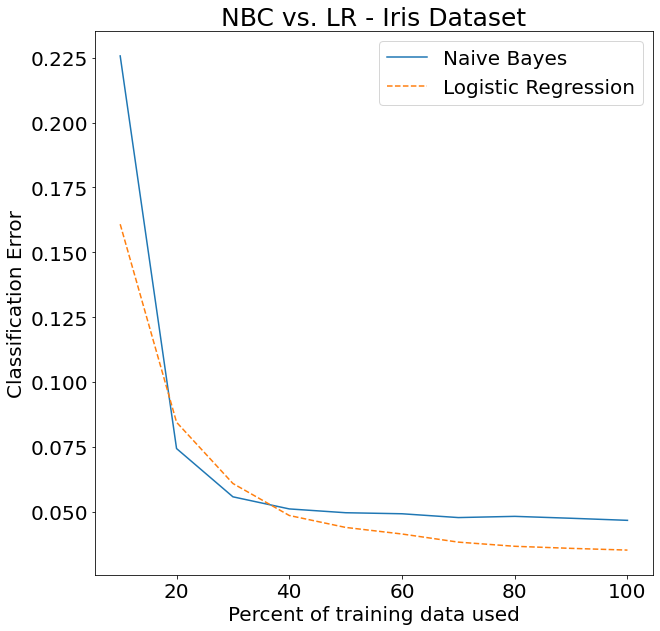

In [ ]:
# Classifier Comparison (with l2 regularization in LR)
## In a first step we define the models
lr = LogisticRegression(max_iter=200, n_jobs=-1)
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
## Then, we calculate the average test error rates
nbc_avg_err, lr_avg_err = compareNBCvsLR(nbc_iris, lr, X, y, 500, 10)
## Finally, we plot the error rates
makePlot(nbc_avg_err, lr_avg_err , 'NBC vs. LR - Iris Dataset')

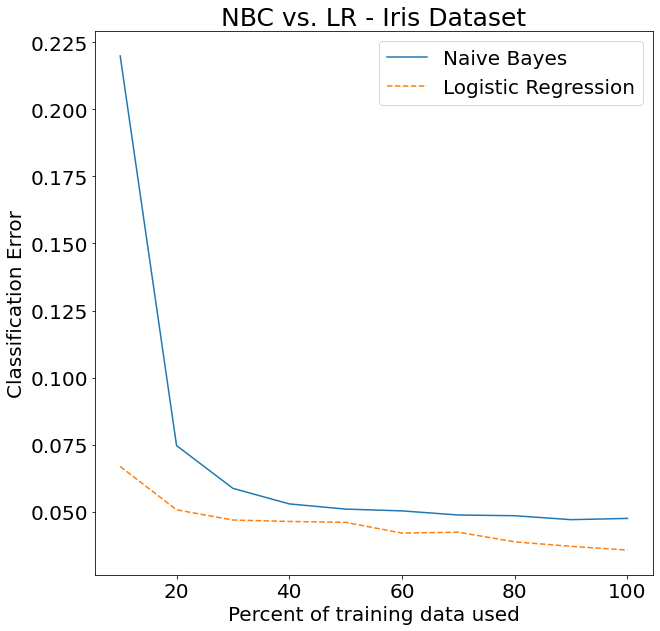

In [ ]:
# Classifier Comparison (with none regularization in LR)
## In a first step we define the models
lr = LogisticRegression(penalty='none', max_iter=200, n_jobs=-1)
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
## Then, we calculate the average test error rates
nbc_avg_err, lr_avg_err = compareNBCvsLR(nbc_iris, lr, X, y, 500, 10)
## Finally, we plot the error rates
makePlot(nbc_avg_err, lr_avg_err , 'NBC vs. LR - Iris Dataset')

**Report on Dataset 1**

In this task we compare both classifiers on the Iris dataset. The Iris dataset consists of four feature types of continuous form with a total of 3 possible classes. Since there are no missing values in the dataset, we do not have to impute any values. Furthermore, as we do not have any binary features that are given in terms of strings or any categorical features, it is not necessary to encode any variable to make the logistic regression work. Consequently, we simply have to ensure that the feature parameters are stored as a numpy array within their respective variable. 

To use the NBC model, we use the code written above and let it run. But for the logistic regression, we further add some important remarks. For one, we saw that the logistic regression has a penalty term, the l2 regulariser, in its default setting. Since we did not add any regularizer terms into our NBC model, we deem that comparability may suffer in case we use the scikit learn default setting and therefore change the setting to None. However, we decided to plot both settings such that the interested viewer is able to distinguish the settings. 

Interestingly, we find that exclusion of the penalty parameter leads to an improvement of results for the logistic regression model. As such, it now is able to outperform the NBC model at any stage of training data used, implying that the inclusion of the penalty parameter negatively affects the accuracy of the logistic regression. 

Overall, we find that both models perform fairly well for a percentage of training data of approximately 30-40 % on. Also, we find that the NBC model has a steeper learning curve when additional training data is added. If we only focus on the logistic regression model for which the penalty term was excluded, we find that, albeit its steep progress in the beginning, NBC no longer improves substantially when having a training data percentage of more than 40% whereas we do see constant improvements for the logistic regression model.

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


In [ ]:
# TODO: insert your code for experiments

# In a first step we load the data
voting = pd.read_csv('./voting.csv')
voting.info()
# Next, we split the data into label and features
## Get the features by choosing all columns of the voting dataframe except the label, which is stored in the column 'label'
features = voting[voting.columns[voting.columns != 'label']]
## Get the label by choosing the column of the voting dataframe that stores the label (i.e. column 'label')
label = voting[['label']]
# As we observe that there are several missing values in the features, we apply value imputation using the multivariate feature imputation technique provided by the
## IterativeImputer from sklearn in the following. However, as this requires the data to be numerical, we first need to bring our data into a suitable format.
## By looking at the data we observe that our data consists solely of categorical features with two classes (i.e. yes/no). Thus, as the features are basically 
## binary variables we transfrom them into dummy variables by replacing each 'y' (for yes) by 1 and each 'n' (for no) by 0
features = features.replace(['y','n'],[1,0])
## Then we transform all features into a numerical type, such that the IterativeImputer can work with the data
features = features.apply(pd.to_numeric)
## Then we perform the actual value imputation. We set the strategy to initialize the missing values to "most frequent" and restrict the imputation values to lie
## within the interval [0,1]. We leave the rest at the default setting.
imputer = IterativeImputer(initial_strategy='most_frequent', min_value=0, max_value=1)
## Fit the imputer
imputer.fit(features)
## Get the a dataframe containing the cleaned features (i.e. features without any missing values)
features = imputer.transform(features) # Note: This step returns a numpy ndarray
## We observe that we indeed managed to impute all missing values
pd.DataFrame(features).info()
## However, since the multinomial imputer created float values, we now transform the features such that we again attain binary variables. To do so, we simply replace
## each value which is weakly above 0.5 by 1, and each value which is below 0.5 by 0.
features[features >= 0.5] = 1
features[features < 0.5] = 0
# Lastly, we assign the features to X and transform the labels into np.ndarrays, such that the NBC works properly
X = features
y = label.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

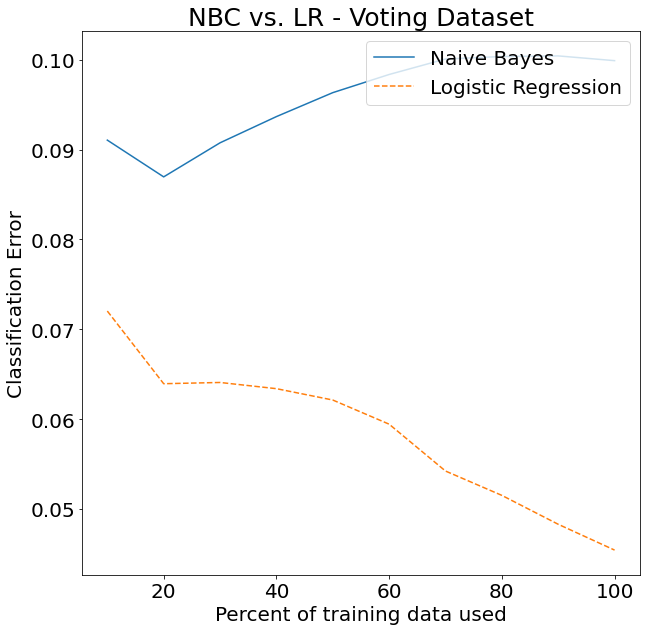

In [ ]:
# Classifier Comparison
## In a first step we define the models. 
## Note that all 16 features are binary.
## Moreover, there are 2 different classes in y.
lr = LogisticRegression(penalty='none', max_iter=200, n_jobs=-1)
nbc_car = NBC(feature_types=np.repeat('b',X.shape[1]), num_classes=2)
## Then, we calculate the average test error rates
nbc_avg_err, lr_avg_err = compareNBCvsLR(nbc_car, lr, X, y, 500, 10)
## Finally, we plot the error rates
makePlot(nbc_avg_err, lr_avg_err , 'NBC vs. LR - Voting Dataset')

**Report on Dataset 2**

In this dataset, we are comparing both models on the voting behaviour of for congressional levels. The main aim is to classify individuals as Republican or Democrat based on their voting behaviour on a number of subjects which passed congress in the 80s. The dataset provides votes to 16 individual votes as predictor variables given in a binary format as well as one label variable, indicating 1 for Democrat and 0 for Republican. 

The first problem appears when analysing the non-zero elements per predictor. As we can see, all predictors do have at least some missing values. In order to be able to work with the dataset, thus, we decide to use a multivariate imputation technique given by the IterativeImputer in the scikit-learn package. Iterative imputation refers to a process where each feature is modeled as a function of the other features. Each feature is imputed sequentially, one after the other, allowing prior imputed values to be used as part of a model in predicting subsequent features. In our case, it serves as a regression problem where missing values are predicted. For simplicity, we are using a linear model.

Doing so requires us to convert the data into a numerical format. This can be easily achieved since the predictors are binary variables, consisting of solely "No" and "Yes" arguments. Thus, we first transform said values into a [0,1] setting where 1 denotes Yes and 0 No. Then, we simply change the datatype into numeric through the apply command. 

Using the imputer method, we initialise the missing values to obtain the most common value of each feature, which, in the case of binary features, can be regarded as median value. Then, iteratively, missing values are to be calculated. 

Importantly, we cannot assign each imputed observation an exactly pre-specified value, but rather can only select a range in which the values must lie. In our case, we defined value range between 0 and 1 to be optimal. Then, in a last step, we used a similar idea followed by classification algorithms and assigned value of 1 for each imputed value with an initial value of larger 0.5 and 0 otherwise, such that each value now has the same potential outcomes in a binary setting. Like that, we were able to reconstruct the dataset. 

Another option would have been to simply deselect the observations for which at least one of the features was missing. However, this would have led to a dramatic decline in observational strength as, in many observations, solely some inputs were missing, which would have required us to exclude even more observations. 

As such, we traded-off data availability for making additional assumptions about the imputability of the dataset. 

Looking at the results, we find that, although both models appear to rather well describe the dataset (with classification errors below 0.1), logistic regression also clearly outperforms the NBC model. Interestingly even, we see that overall the NBC has a somewhat convex curve in its classification error, while logistic regression gradually declines with increased training data, as would be expected. Also, the differences in slopes appears to be occuring at the same training data percentage for both models, which is roughly around 20%. One reason for this might be that the assumptions of NBC are not fulfilled in this dataset. That is, we cannot assume that the predictor variables are independent of each other. In the case of political decision-making, this is quite intuitive. Considering polticial standpoints and party affiliations, it is rather clear that the vote on one subject might strongly correlate with the voting behaviour of different subjects. 

Further, another aspect might be that, due to the logistic regression's greater flexibility, it was able to better account for the classifications given by our imputation strategy. This might be due to the fact that we mimic the logistic regression classification strategy through our imputations, by assigning a cut-off point at a value of 0.5. As such, the model might be better equipped to operate under such conditions. 

**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

In [ ]:
# TODO: insert your code for experiments

# In a first step we load the data
car = pd.read_csv('./car.csv')
car.info()
# Note: As we observe that there are no missing values in the data, we don't have to perform any value inputation.
# Thus, we split the dataframe into X (features) and y (label)
## Get the features by choosing all columns of the car dataframe except the label, which is stored in the column 'acceptability'
features = car[car.columns[car.columns != 'acceptability']]
## Get the label by choosing the column of the car dataframe that stores the label (i.e. column 'acceptability')
label = car[['acceptability']]
# By looking at the data we observe that our data consists of categorical features, which cause problem when estimating the logistic regression.
## Thus, we use one hot encoding to transform each categorical feature into indicator variables for each category.
## Note: To prevent multicollinearity issues, we drop the intercept in the logistic regression model later on.
features = pd.get_dummies(features, drop_first=False)
# Lastly, we transform the features and labels into np.ndarrays, such that the NBC works properly
X = features.to_numpy()
y = label.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   buying         1728 non-null   object
 1   maint          1728 non-null   object
 2   doors          1728 non-null   object
 3   persons        1728 non-null   object
 4   lug_boot       1728 non-null   object
 5   safety         1728 non-null   object
 6   acceptability  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


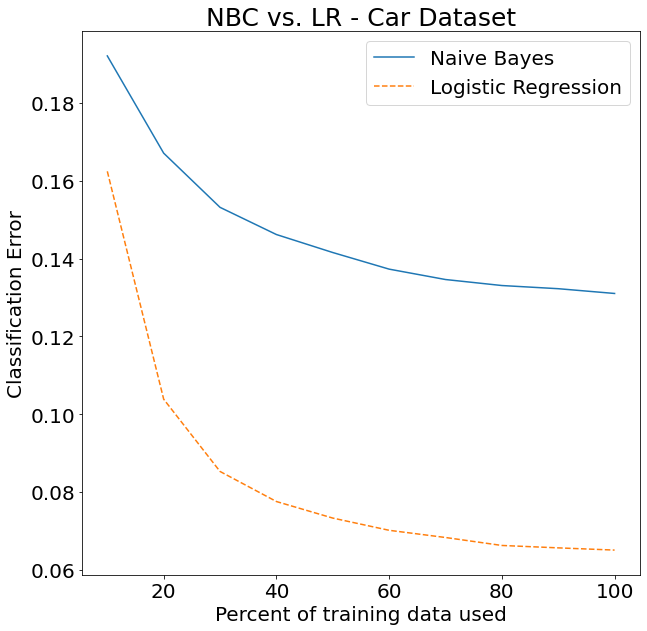

In [ ]:
# Classifier Comparison
## In a first step we define the models. 
## Note that all categorical features are transformed into binary ones, which leads to 21 binary features.
## Moreover, there are 4 different classes in y.
lr = LogisticRegression(penalty='none', max_iter=200, n_jobs=-1, fit_intercept=False)
nbc_car = NBC(feature_types=np.repeat('b',X.shape[1]), num_classes=4)
## Then, we calculate the average test error rates
nbc_avg_err, lr_avg_err = compareNBCvsLR(nbc_car, lr, X, y, 500, 10)
## Finally, we plot the error rates
makePlot(nbc_avg_err, lr_avg_err , 'NBC vs. LR - Car Dataset')

**Report on Dataset 3**

In this dataset, we use both models to predict acceptability status of a car based on 6 characteristics. 

Luckily, this time we do not observe any missing values. As such, no data exclusion or imputation strategy must be adhered to. 

However, what we can see is that the dataset only consists of categorical features. Therefore, we use a one hot encoding strategy to set each observation to its respective "binary code". Also, as we do incorporate potential multi-colliniarity issues when estimating the logistic regression, we decide to drop the intercept from the logistic regression model. Note that we decide to transform categorical into binary features since logistic regression, in its setting, can only understand either binary or continuous features. 

Taken all steps together, we can observe that, also in this case, logistic regression gradually outperforms the NBC model. Especially, we find that, although both classifiers act as expected in the case of increasing training data, logistic regression has an especially steep decline in the first few steps and then commences to resemble the slope of NBC. This occurs at roughly 40%. 

As such, we can observe that also in this case the model assumptions of the NBC appear not to hold for the given data. Also here, one could argue that the feature variables are very much likely to depend on each other to at least some extent, such as the number of people the car can transport and the number of doors the car has. Another reason might also be that it is likely the case that categorical features which do not incorporate a large variance within each group might account for a large part of the class-conditional variables. For instance, number of doors, people or security standards are represented by very few category options. As such, if these features obtain a large weight in the NBC despite their similarity, the classifier might have larger problems in finding distinguishable features. To that extend, we also find that nearly 70% of the dataset consists of the same outcome variable. As such, if many different feature combinations would lead to the same categorical outcome (e.g. unacceptable) this could further disadvantage the algorithm to conduct an accurate classification. 


**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

In [ ]:
# TODO: insert your code for experiments

# In a first step we load the data
cancer = pd.read_csv('./breast-cancer.csv')
cancer.info()
# Note: As we observe that there are no missing values in the data, we don't have to perform any value inputation.
# Thus, we split the dataframe into X (features) and y (label)
## Get the features by choosing all columns of the cancer dataframe except the label, which is stored in the column 'Class'
features = cancer[cancer.columns[cancer.columns != 'Class']]
## Get the label by choosing the column of the cancer dataframe that stores the label (i.e. column 'Class')
label = cancer[['Class']]
# By looking at the data we observe that our data consists of categorical features, which cause problem when estimating the logistic regression.
## Thus, we use one hot encoding to transform each categorical feature into indicator variables for each category.
## Note:
### Since the feature 'deg-malig' is regognized as an integer, we first need to transform this feature into a category.
### To prevent multicollinearity issues, we drop the intercept in the logistic regression model later on.
features['deg-malig'] = features['deg-malig'].astype(object)
features = pd.get_dummies(features, drop_first=False)
# Lastly, we transform the features and labels into np.ndarrays, such that the NBC works properly
X = features.to_numpy()
y = label.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


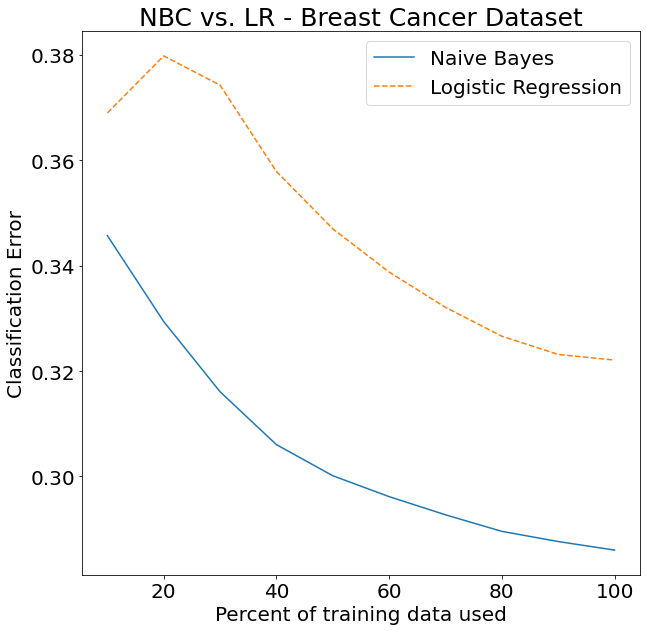

In [ ]:
# Classifier Comparison
## In a first step we define the models. 
## Note that all categorical features are transformed into binary ones, which leads to 43 binary features.
## Moreover, there are 2 different classes in y.
lr = LogisticRegression(penalty='none', max_iter=200, n_jobs=-1, fit_intercept=False)
nbc_cancer = NBC(feature_types=np.repeat('b',X.shape[1]), num_classes=2)
## Then, we calculate the average test error rates
nbc_avg_err, lr_avg_err = compareNBCvsLR(nbc_cancer, lr, X, y, 500, 10)
## Finally, we plot the error rates
makePlot(nbc_avg_err, lr_avg_err , 'NBC vs. LR - Breast Cancer Dataset')

**Report on Dataset 4**

In this dataset, we are comparing the model performance on breast cancer classes. For that, we obtain 286 observations which are predicted through nine distinct features. 

In this taks, we can follow a roughly similar data preparation approach as before. As we can see, there are no missing values throughout any observation so we do not need to follow any imputation or data exclusion strategy as was requried in Task 2. 

Further, we can see that nearly all feature variables are stored as categorical variables, with category sizes ranging from 2 (for irradiant) to 9 (for tumor size). The only difference is currently given for the feature "deg-malig", which is treated as an integer. In order to account for this, we transform it first into a categorical feature before applying the same "binary transformation" strategy as we did in the tasks before. After dropping the intercept from the linear regression model for collinearity considerations, we can again run both models.

As we can see, now NBC clearly outperforms the Logistic Regression. Interestingly, this is the first model in which, despite the increasing training data percentage, the logistic model is unable to catch up with the NBC, although both models substantially improve when being exposed to a higher amount of training data. Although reasons for this might be manifold, one could argue that, in this specific case, the NBC is potentially better equipped to work with this set of features, implying that Logistic regression potentially has some trouble in converting the (potentially manifold categories) into binary values. Another reason might consitute that the NBC conditions of class-conditional independence are more fulfilled compared to other data settings. This, however, would require us to assume that the indications on age as well as menopause cannot substantially influence the model, since we would expect a clear dependence between both variables. 

Overall, one could also argue that both models perform considerably worse compared to the other data settings we previously encountered. As such it might also be considered that not just the model setting, but perhaps the choice of features, or observations, is somewhat inappropriate to consider the underlying relationship. As such, one could potentially argue that more the choice of covariates and less the model setting should be reevaluated. 


**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

In [ ]:
# TODO: insert your code for experiments

# In a first step we load the data
ionosphere = pd.read_csv('./ionosphere.csv')
ionosphere.info()
# Note: As we observe that there are no missing values in the data, we don't have to perform any value inputation.
# Thus, we split the dataframe into X (features) and y (label)
## Get the features by choosing all columns of the ionosphere dataframe except the label, which is stored in the column 'label'
features = ionosphere[ionosphere.columns[ionosphere.columns != 'label']]
## Get the label by choosing the column of the ionosphere dataframe that stores the label (i.e. column 'label')
label = ionosphere[['label']]
# By looking at the data we observe that our data consists of binary and continuous features.
## As we observe that one of the binary features (i.e. feature 2) has only 0 as entries, we drop it, since it does not add any predictive power.
features = features.drop('feature2', axis=1)
# Lastly, we transform the features and labels into np.ndarrays, such that the NBC works properly
X = features.to_numpy()
y = label.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   351 non-null    int64  
 1   feature2   351 non-null    int64  
 2   feature3   351 non-null    float64
 3   feature4   351 non-null    float64
 4   feature5   351 non-null    float64
 5   feature6   351 non-null    float64
 6   feature7   351 non-null    float64
 7   feature8   351 non-null    float64
 8   feature9   351 non-null    float64
 9   feature10  351 non-null    float64
 10  feature11  351 non-null    float64
 11  feature12  351 non-null    float64
 12  feature13  351 non-null    float64
 13  feature14  351 non-null    float64
 14  feature15  351 non-null    float64
 15  feature16  351 non-null    float64
 16  feature17  351 non-null    float64
 17  feature18  351 non-null    float64
 18  feature19  351 non-null    float64
 19  feature20  351 non-null    float64
 20  feature21 

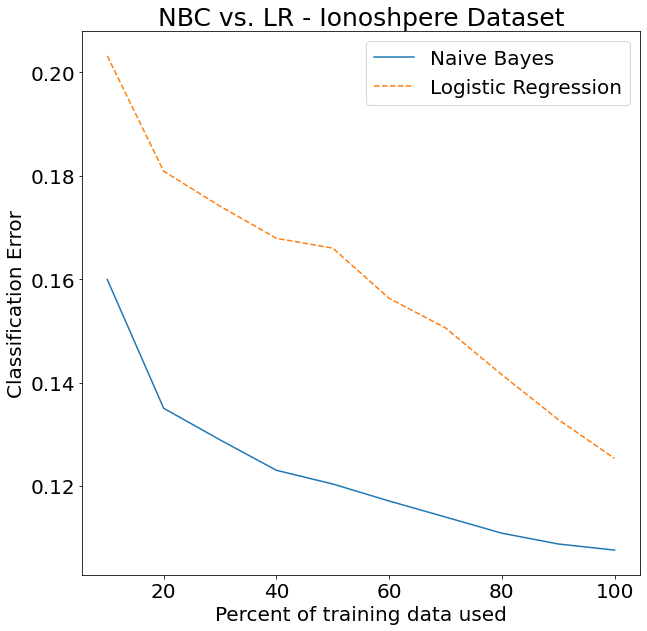

In [ ]:
# Classifier Comparison
## In a first step we define the models. 
## Note that we have solely continuous features. In particular 33 of them.
## Moreover, there are 2 different classes in y.
lr = LogisticRegression(penalty='none', max_iter=200, n_jobs=-1)
nbc_ionosphere = NBC(feature_types=np.repeat('r',X.shape[1]), num_classes=2)
## Then, we calculate the average test error rates
nbc_avg_err, lr_avg_err = compareNBCvsLR(nbc_ionosphere, lr, X, y, 500, 10)
## Finally, we plot the error rates
makePlot(nbc_avg_err, lr_avg_err , 'NBC vs. LR - Ionoshpere Dataset')

**Report on Dataset 5**


In this dataset we look at the classification of radar returns from the ionosphere and attempt to model a binary outcome, as either good or bad signals. 

Looking at the data preparation process, we find that now we face a dataset with a considerable amount of predictor variables, all of which are described to be continuous features. Further, we don't have any missing values which allows us to continue without imputation considerations. Further, as we have no categorical features, we can also disregard binarification of these variables. 

Importantly, we see that the Feature 2 is 0 for each entry and thus adds no predictive power. As such, we can just drop this feature manually, as including it would not help the models to make better predictions.

When we now look at the model, we see a similar pattern compared to the dataset on Breast Cancer. Interestingly, we can also observe that both models improve quite similarily when adding more data, although the logistic regression model appears to have a steeper descent when a threshold of 40% of the training data is reached. This would again support theory claiming that NBC converges more quickly than logistic regression models. However, as in the case of Breast Cancer, despite this seemingly quicker convergence, and the steep improvements of logistic regression when adding more than approximately 70% to training data, it is unable to catch up with the NBC model. 

Further, we could also consider that regularisation might be appropriate given the number of covariates in comparison with the number of observations (34 to 351). As such, we can expect that the model was overfitting with a small training size and only started to adjust the fit once a more appropriate datasize was provided. As such, it might be not surprising that the logistic regression model increases its steep descent continuously even after more than 70% of the training data is used. Remember that we decided against using the regularisation option in the logistic regression for the sake of a better comparability of both models.

Another implication for the dominance of the NBC in said setting might be, as already described in the Breast Cancer dataset, that the assumption of class-conditional independence is more fulfilled compared to other data settings.

However, due to our context-specific limitations (as that we are not scientists in this field) and based on the fact that the features are only labeled as "features" and thus have no actual meaning to us, we cannot conclude anything further, such as if the features are actually the right ones for this model or whether additional feature selection could indeed provide an improved basis for our models. 



**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

In [ ]:
# TODO: insert your code for experiments

# In a first step we load the data
sonar = pd.read_csv('./sonar.csv')
sonar.info()
# As we observe that there are no missing values in the data, we don't have to perform any value inputation.
# Hence, we simply transform the features and the label into np.ndarrays to use them subsequently
## Get X by choosing all columns of the sonar dataframe except the label, which is stored in the column 'label'
X = sonar[sonar.columns[sonar.columns != 'label']].to_numpy()
## Get y by choosing the column of the sonar dataframe that stores the label (i.e. column 'label')
y = sonar[['label']].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   208 non-null    float64
 1   feature2   208 non-null    float64
 2   feature3   208 non-null    float64
 3   feature4   208 non-null    float64
 4   feature5   208 non-null    float64
 5   feature6   208 non-null    float64
 6   feature7   208 non-null    float64
 7   feature8   208 non-null    float64
 8   feature9   208 non-null    float64
 9   feature10  208 non-null    float64
 10  feature11  208 non-null    float64
 11  feature12  208 non-null    float64
 12  feature13  208 non-null    float64
 13  feature14  208 non-null    float64
 14  feature15  208 non-null    float64
 15  feature16  208 non-null    float64
 16  feature17  208 non-null    float64
 17  feature18  208 non-null    float64
 18  feature19  208 non-null    float64
 19  feature20  208 non-null    float64
 20  feature21 

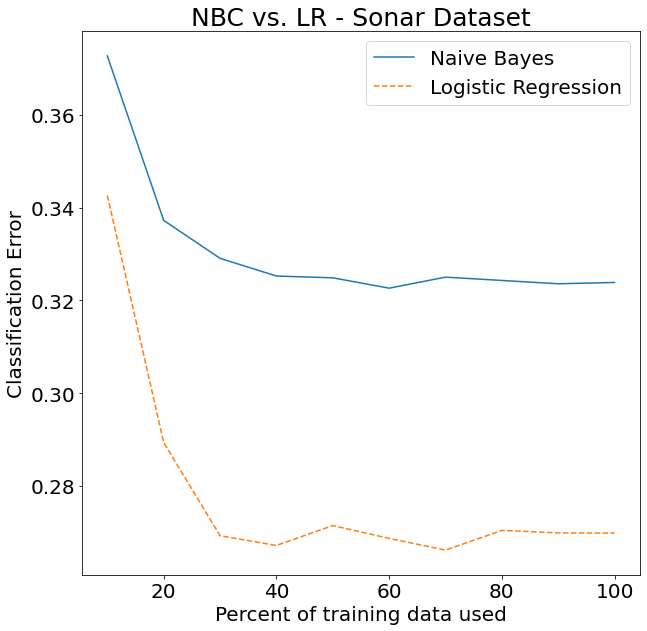

In [ ]:
# Classifier Comparison
## In a first step we define the models. 
## Note that we have solely continuous features. In particular 60 of them.
## Moreover, there are 2 different classes in y.
lr = LogisticRegression(penalty='none', max_iter=200, n_jobs=-1)
nbc_sonar = NBC(feature_types=np.repeat('r',60), num_classes=2)
## Then, we calculate the average test error rates
nbc_avg_err, lr_avg_err = compareNBCvsLR(nbc_sonar, lr, X, y, 500, 10)
## Finally, we plot the error rates
makePlot(nbc_avg_err, lr_avg_err , 'NBC vs. LR - Sonar Dataset')

**Report on Dataset 6**

In the last dataset, we are looking at sonar waves. The task is to train a network to discriminate between sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock. Also here, we do not have any knowledge on the subject itself and can thus only argue from a model perspective. 

First, we see again that we do not have to follow any imputation techniques as we don't have any missing values. Also, we can see that each feature has sufficient variation such that it adds predictive power to the model, which means that we do not have to exclude one for simply adding noise. 

In general, we have only continuous predictors and a binary classification. Also, interestingly, we find that the distribution of classifications is roughly equal for both classes. This could potentially account for some classification issues due to predominance of a certain class within a dataset. 

Coming to the output, what is interesting here is that Logistic Regression appears to outperform again the NBC in all stages of training data used. Especially, it shows a steeper decline but then converges at approximately the same percentage of training data used, going against the assumption of quicker convergence for NBC models. In this specific case, one could argue that the feature-datasize ratio is especially severe in this case. Remember that we have currently over 60 continuous features given on solely 208 observations, which might lead to a severe overfitting of our model. As such, the inclusion of a regularisation term in our model, preferably even a l-1 regularisation (Lasso), might improve the obtained results, as it appears as if the obtained error, for the logistic regression, would even further decline when adding more training data, as given by the negative spike at around 90%. 

However, based on the lack of subject-specific expertise, we cannot rule out the fact that indeed all of these covariates are important in explaining classification status. However, from a model-based point of view, one could argue that a more sparse modelling could lead to improved results. 

## **Final Report on Practical 2**

In this report we again describe to the reader how we approached the problem, which steps have been followed in what period, how we assembled information and obtained a progress determination and how the teamwork functioned throughout the exercise.

We quickly started the second Problem Set after we were able to finish the first one. Also here, we deemed it best that each group member initially obtained a fundamental understanding of the material. As opposed to the first project, neither group member had a deeper understanding of the statistical concepts that were discussed for the Problem Set. As such, the subject of generative models had to be rolled up from the beginning in order to understand the fundamental concepts. Doing so required us to read through several textbook chapters and follow online tutorials, which consumed roughly a week before we were able to obtain the necessary theoretical knowledge to start the project. In this period, we mainly worked together on a day-to-day basis and tried to answer each other's questions on a continuous period. The project start was again individually organised, simply because, this time, we had an even greater heterogeneity in our curricula, which made it impossible for the group members to commence the project at the same time. Also, this again helped us to define individually how the project should be approached and decide for oneself at what step which problems arise. After each group member then started the project, we again had 2 rounds of discussions in which we defined the progress and discussed preliminary results. However, this time, as we did not have much time to invest into the assessment, we mainly worked based on the results we obtained from the prediction accuracy scores. This implies that we worked rather on a result- instead of an approach-based basis. Still, despite this strategy, we were still able to obtain similar results. However, we must confess that especially in this part, heterogeneity in programming experience was more clearly visible compared to the first part. Although both group members were able to obtain a code which overall worked and provided the desired results, differences in programing style and ability to execute were apparent for some parts of the code. As such, what we may critisize in this project is the fact that, unfortunately, we both did not have a sufficient amount of time to discuss the necessary steps taken in each section of the code, which then lead to frictions in the executability of the program. Mainly, this was based on the fact that both had a rather full agenda to follow and, as we knew that the third practical may require even more time than the second, we deemed it nevertheless necessary to finish the second project in time, as otherwise the study period might be too sparse to fully incorporate other subjects. As such, we faced a trade-off between time efficiency and cooperability, at which we decided to trade the latter for the former. However, as time pressure is a constant factor in these projects, we still believe that we were able to trade both issues off in a manner that was acceptable for the group members.
